
# Logistic regression model (bank cards operations)

------------------------------------------------------------------------------------------------------------------------

# Introduction

Logistic regression is algorithm of classification machine learning. Model predicts binary state of dependent variable. Dependent result variable takes value from 0 to 1.

# Main principles of logistic regression model
1. Dependent variable has a binary form.
2. Model contain only variables who have significant influence on the result.
3. There are no collinearity among independent variables (no correlation among predictors).
4. Logistic model needs big number of observations.

Let's open data with needed libraries. We will be working on the registry of bank cards operations. In colum 'Class' value 0 mean: lack of fraud in transaction, value 1 point embezzlement. Let's take an assumption, main aim is to correctly classification of transactions with embezzlement. We can unfortunately certificate good transaction as the transaction with fraud.

In [1]:
## Procedura Logistic Regression DLA ZMIENNYCH OPISUJĄCYCH CIĄGŁYCH 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Normalizer, scale
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('c:/1/creditcard.csv')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0


In [2]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

# Analyze of the level of balance of the dependent variables

Assembly of variable is balanced when values 1 and 0 have likely number of occurrences. Result variables assembly is unbalanced because the subject of investigation rare phenomenon (showed as 1). Variable 1 is appeared one of the 1000 transaction marked as 0. When the variable assembly is unbalanced, then we can appear phenomenon, where model would be ignored minority variable (marked as 1). Such model has very high level of 'recall' ratios, despite ignore even all 1 variables.

We check out level of unbalanced in registry.

In [3]:
df.Class.value_counts(dropna = False)

0.0    17400
1.0       80
NaN        1
Name: Class, dtype: int64

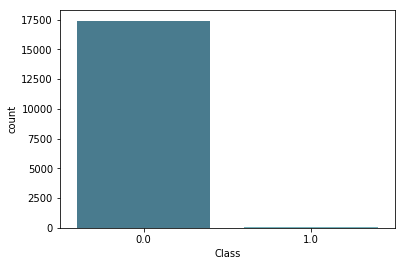

In [4]:
sns.countplot(x='Class',data=df, palette='GnBu_d')
plt.show()

The plot is not very readable. We make the percentage structure.

# Analyze of independent variables in the logistic regression model

Let's remind two important assumptions for logistic regression.
1. Inmodel, we ought to took only independent variables who have significant influence on the result variable.
2. Independent variable should be mutual non correlated.

In the first stage we check how independent variables influence on the result variable.

In [5]:
df.Class.value_counts(dropna = False, normalize=True)

0.0    0.995366
1.0    0.004576
NaN    0.000057
Name: Class, dtype: float64

I check what the amount on transaction with fraud and on regular transaction.

In [6]:
df.groupby('Class').Amount.mean() 

Class
0.0    66.927028
1.0    98.082375
Name: Amount, dtype: float64

In [7]:
df.Amount.agg(['min','max','mean','std']).astype(int)

min        0
max     7712
mean      67
std      188
Name: Amount, dtype: int32

As we see scale of fraud, represented as 1 in column 'Class', poses only 0,46% of all transactions. So, the assembly is deeply unbalanced. 

In the first stage we check how independent variables influence on the result variable.

In [8]:
CORREL = df.corr().sort_values('Class')
CORREL['Class']

V3       -0.524607
V14      -0.482336
V17      -0.474386
V7       -0.441136
V10      -0.393678
V16      -0.369733
V12      -0.349516
V1       -0.315801
V5       -0.297279
V18      -0.235021
V9       -0.204471
V6       -0.136283
V23      -0.044445
V24      -0.034291
V22      -0.026568
V13      -0.016051
V15      -0.006326
Amount    0.011165
V26       0.018321
V28       0.021741
Time      0.022051
V25       0.032994
V19       0.038577
V21       0.048056
V20       0.078527
V27       0.157495
V8        0.233020
V4        0.281417
V2        0.287273
V11       0.309185
Class     1.000000
Name: Class, dtype: float64

Correlation vector show, that some of the independent variables have small or none influence on the result.

# Statistical analysis of independent variables

We check how is the difference between 1 and 0 in the 'Amount' and 'Time' of transactions.

In [9]:
pd.pivot_table(df, index='Class', values = 'Amount', aggfunc= [np.mean, np.median, min, max, np.std] )

,mean,median,min,max,std
,Amount,Amount,Amount,Amount,Amount
Class,,,,,
0.0,66.927028,15.95,0.0,7712.43,187.89952
1.0,98.082375,1.00,0.0,1809.68,269.15147


In [10]:
pd.pivot_table(df, index='Class', values = 'Time', aggfunc= [np.mean, np.median, min, max, np.std])

,mean,median,min,max,std
,Time,Time,Time,Time,Time
Class,,,,,
0.0,13515.67069,11854.0,0,28753,9702.669336
1.0,16684.05000,17203.5,406,28726,8184.483331


We point the columns who have any correlation upper than 0.4 with dependent variable.

In [11]:
kot = CORREL[(CORREL['Class']>0.4)|(CORREL['Class']<-0.3)][['Class']]
kot.index

Index(['V3', 'V14', 'V17', 'V7', 'V10', 'V16', 'V12', 'V1', 'Class'], dtype='object')

We collected only variables strong correlated with result variable.

In [12]:
CORREL = df[['V3', 'V14', 'V17', 'V7', 'V10', 'V16', 'V12', 'V1', 'Class']].corr().sort_values('Class')
CORREL['Class']

V3      -0.524607
V14     -0.482336
V17     -0.474386
V7      -0.441136
V10     -0.393678
V16     -0.369733
V12     -0.349516
V1      -0.315801
Class    1.000000
Name: Class, dtype: float64

We rather don't use 'Amount' to the model. For example, we do standardization of this category.

In [13]:
#scaler = StandardScaler()
#df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

Let's check correlation among independent variables.

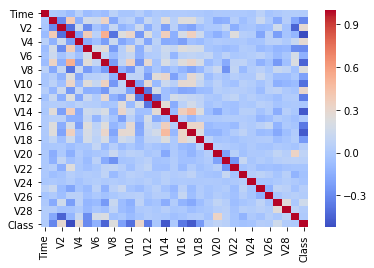

In [14]:
sns.heatmap (df.corr (), cmap="coolwarm")

Before we start compose model we will need to do order in data.
1. We remove columns what we will do not use.
2. We remove records with the lack (empty) values.
3. We do not standardized data.
4. We check statistic parametrs of the data.

In [15]:
#df.drop(columns = 'Time', inplace = True)    
#del df['Amount']                             

df.isnull().sum()                             
df = df.dropna(how='any')                    

df.agg(['min','max','mean','std'])[['V3', 'V14', 'V17', 'V7', 'V10', 'V16', 'V12', 'V1', 'Class']]  

,V3,V14,V17,V7,V10,V16,V12,V1,Class
min,-30.558697,-19.214325,-18.587366,-26.548144,-14.166795,-12.227189,-17.769143,-29.876366,0.000000
max,4.101716,7.692209,9.253526,34.303177,12.701538,4.816252,3.774837,1.960497,1.000000
mean,0.780300,0.652533,0.324366,-0.148176,-0.256112,-0.024921,-1.254557,-0.251191,0.004577
std,1.758847,1.351563,1.260242,1.340792,1.247107,0.964966,1.583679,1.889182,0.067498


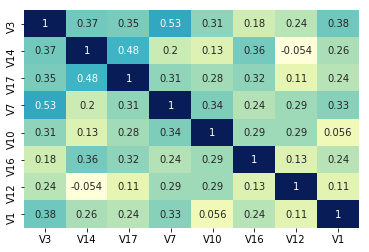

In [48]:
sns.heatmap (df[['V3', 'V14', 'V17', 'V7', 'V10', 'V16', 'V12', 'V1']].corr(), cmap="YlGnBu", annot=True, cbar=False)

We can find any significant mutual correlation between independent variables. Before we start creating the model we ought to remove all records with empty cells.

# Creating model of logistic regression

We declare where is independent, descriptive variables and dependent, result variable. We point the divide of training and test assemblies.

In [16]:
feature_cols = ['V3', 'V14', 'V17', 'V7', 'V10', 'V16', 'V12', 'V1']
X = df[feature_cols] 
y = df.Class

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .33, stratify = y, random_state = 148)

We are configure settings for grid. 

In [17]:
Parameteres = {'C': np.power(10.0, np.arange(-3, 3))}
LR = LogisticRegression(warm_start = True)
LR_Grid = GridSearchCV(LR, param_grid = Parameteres, scoring = 'roc_auc', n_jobs = 5, cv=2)

Explanation for the code:

# Parameteres

Parameteres = {'C': np.power(10.0, np.arange(-3, 3))}
array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
We have tipical setting for the grid.

# warm_start
Using 'warm_start=True' causes utilization of last model setting to next run of the model. Thank to this model speeds up time of finding convergence. Parameter warm_start is useful in making multiple convergences with the same model using various settings.

# scoring = 'roc_auc'
The ROC plot estimates the best of setting of classification. Finding the area under the ROC curve is the most popular method of evaluation of classification efficiency by the grid.

# jobs = 5
Number of tasks running simultaneously

# cv = 2
Number of cross verifications.
Model takes the form of the equation:

In [50]:
LR_Grid.fit(Xtrain, ytrain) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=True),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

We check what of supermatamiters have been chosen as the best by the grid.

In [19]:
print("The Best parameter:",LR_Grid.best_params_)
print("The Best estimator:",LR_Grid.best_estimator_)

The Best parameter: {'C': 1.0}
The Best estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)


# Evaluation of the classification of the logistic regression

We use diagnostic block, we put it into the code.


------Training data---------------------------------------------------
The RECALL Training data:       0.648
The PRECISION Training data:    0.686

------Test data-------------------------------------------------------
The RECALL Test data is:         0.615
The PRECISION Test data is:      0.667

The Confusion Matrix Test data :--------------------------------------
[[5735    8]
 [  10   16]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5743
         1.0       0.67      0.62      0.64        26

   micro avg       1.00      1.00      1.00      5769
   macro avg       0.83      0.81      0.82      5769
weighted avg       1.00      1.00      1.00      5769



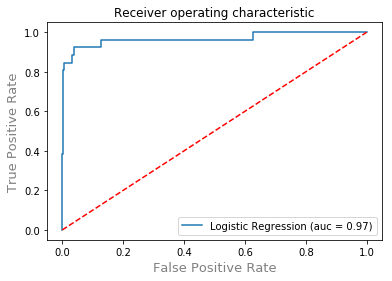

In [20]:
print("\n------Training data---------------------------------------------------")
print("The RECALL Training data:      ", np.round(recall_score(ytrain, LR_Grid.predict(Xtrain)), decimals=3))
print("The PRECISION Training data:   ", np.round(precision_score(ytrain, LR_Grid.predict(Xtrain)), decimals=3))
print()
print("------Test data-------------------------------------------------------")

print("The RECALL Test data is:        ", np.round(recall_score(ytest, LR_Grid.predict(Xtest)), decimals=3))
print("The PRECISION Test data is:     ", np.round(precision_score(ytest, LR_Grid.predict(Xtest)), decimals=3))
print()
print("The Confusion Matrix Test data :--------------------------------------")
print(confusion_matrix(ytest, LR_Grid.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, LR_Grid.predict(Xtest)))

# PLOT
y_pred_proba = LR_Grid.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % auc)
#plt.axvline(0.5, color = '#00C851', linestyle = '--')
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

The 'Recall' gauge increased to the level of 0.62, ratios 'precision' fall to the level 0.67.

# Changing of the threshold on the logistic regression

--------------------------------------------------------------------------------------------
Changing of the threshold on the logistic regression increase level of 'recall' in the expense of level of accuracy shown by the 'precision' ratio. Let's remind, bank track all fraud and defraud nations made on the credit cards. Cost of false accusation, when the model call clear transaction as the fraud is relatively small. Let's remind, bank track all fraud and defraud nations made on the credit cards. Cost of false accusation, when the model call clear transaction as the fraud is relatively small. Bank especially interested in find fraud at all cost.

In the logistic regression model default threshold is 0,5%. We move threshold to the level of 0,1%.

In [21]:
LR_Grid_ytest = LR_Grid.predict_proba(Xtest)[:, 1]
new_threshold = 0.1 
ytest_pred = (LR_Grid_ytest >= new_threshold).astype(int)

In [22]:
ytest_pred

array([0, 0, 0, ..., 0, 0, 0])

We launch diagnostic module.


------Training data---------------------------------------------------
RECALL Training data (new_threshold = 0.1):       0.648
PRECISION Training data (new_threshold = 0.1):    0.686
------Test data-------------------------------------------------------
RECALL Test data (new_threshold = 0.1):         0.731
PRECISION Test data (new_threshold = 0.1):      0.576

The Confusion Matrix Test data (new_threshold = 0.1):-----------------
[[5729   14]
 [   7   19]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5743
         1.0       0.58      0.73      0.64        26

   micro avg       1.00      1.00      1.00      5769
   macro avg       0.79      0.86      0.82      5769
weighted avg       1.00      1.00      1.00      5769



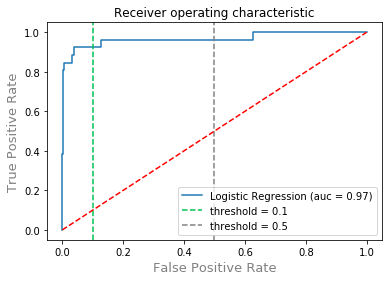

In [23]:
print("\n------Training data---------------------------------------------------")
print("RECALL Training data (new_threshold = 0.1):      ", np.round(recall_score(ytrain, LR_Grid.predict(Xtrain)), decimals=3))
print("PRECISION Training data (new_threshold = 0.1):   ", np.round(precision_score(ytrain, LR_Grid.predict(Xtrain)), decimals=3))

print("------Test data-------------------------------------------------------")

print("RECALL Test data (new_threshold = 0.1):        ", np.round(recall_score(ytest, ytest_pred), decimals=3))
print("PRECISION Test data (new_threshold = 0.1):     ", np.round(precision_score(ytest, ytest_pred), decimals=3))
print()
print("The Confusion Matrix Test data (new_threshold = 0.1):-----------------")
print(confusion_matrix(ytest, ytest_pred))
print("----------------------------------------------------------------------")
print(classification_report(ytest, ytest_pred))

# WYKRES-------------------------------------------
y_pred_proba = LR_Grid.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % auc)
plt.axvline(0.1, color = '#00C251', linestyle = '--', label = 'threshold = 0.1')
plt.axvline(0.5, color = 'grey', linestyle = '--', label = 'threshold = 0.5')
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')

plt.show()

The 'Recall' gauge increased to the level of 0.73, ratios 'precision' fall to the level 0.58.

# Oversampling

--------------------------------------------------------------------
Oversampling is the method of partial removal of effects of unbalanced set of result variables. Method is use for the train set to training the model. When the result registry is not balanced, model have tendency to avoid rare results (1) for the benefit of frequent results (0). Frankly speaking all models have tendency to generalize of the reality. From the bank point of view it is more important to point malversation, despite the model can call proper transaction as fraud, than avoid couple of fraud in the registry. Sensitization of the model for the rare variables is possible by the oversampling and by the move of border of probability. Model sensitization on the frauds move down level of 'Precision' on the benefit of 'recall' ratio.

# Oversampling by the cloning
Random oversampling consist in supplement minority variables by the copy of this minority variables. Oversampling (copying) can be create more than one times (2x, 3x, 5x, 10x et cetera)

# Undersampling by the eliminate
Random undersample consist on elimination of samples from the class of majority (class 0) with the exchange or not. This is one of the earliest techniq of eliminate unbalancing in datasets. Undersampling can increase of variance of the clasificator and teoretycaly trow out usefull variables. 
Source of data: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

# Procedure of oversampling
Let's remind how unbalanced is our dataset.

In [24]:
df.Class.value_counts(dropna = False, normalize=True)

0.0    0.995423
1.0    0.004577
Name: Class, dtype: float64

Minority variables poses only 0.46% of all result variables. It means that for one transaction with the fraud (marked 1) falls 217 clear transaction (marked 0). Let's try to imitate this dependencies on the training set.

In [25]:
print("ytrain = 0: ", sum(ytrain == 0))
print("ytrain = 1: ", sum(ytrain == 1))

ytrain = 0:  11657
ytrain = 1:  54


In [26]:
###### OVERSAMPLING  #######################################

OVS_gauge = sum(ytrain == 0) / sum(ytrain == 1)
OVS_gauge = np.round(OVS_gauge, decimals=0)
OVS_gauge = OVS_gauge.astype(int)
OVS_gauge

216

In the training set for the one fraud falls 216 regular transaction. As we see train set remains with the same proportion to the all set thanks to parameter (stratify = y) in equation who define division in training set and test set. Now we can increase by 217 number of dependent variables marked as 1.

In [27]:
ytrain_pos_OVS = pd.concat([ytrain[ytrain==1]] * OVS_gauge, axis = 0) 
ytrain_pos_OVS.count()

11664


This number is the sum of fraud variables in the training set (there are 54 such variables) multiplied by 216. Now we ought to do it for all independent variables X everywhere where result y was 1.

In [28]:
#Xtrain.loc[ytrain==1, :]

In [29]:
Xtrain.count()

V3     11711
V14    11711
V17    11711
V7     11711
V10    11711
V16    11711
V12    11711
V1     11711
dtype: int64

In [30]:
Xtrain.loc[ytrain==1, :].count()

V3     54
V14    54
V17    54
V7     54
V10    54
V16    54
V12    54
V1     54
dtype: int64

This records with y=1 should be multiplied 216 times.

In [31]:
Xtrain_pos_OVS = pd.concat([Xtrain.loc[ytrain==1, :]] * OVS_gauge, axis = 0)

Now we enter new, additional variables to the training set.

In [32]:
# concat the repeated data with the original data together
ytrain_OVS = pd.concat([ytrain, ytrain_pos_OVS], axis = 0).reset_index(drop = True)
Xtrain_OVS = pd.concat([Xtrain, Xtrain_pos_OVS], axis = 0).reset_index(drop = True)

At the beginning of the study we had 11711 records in dataset.

In [33]:
Xtrain_pos_OVS.count()

V3     11664
V14    11664
V17    11664
V7     11664
V10    11664
V16    11664
V12    11664
V1     11664
dtype: int64

In [34]:
ytrain_OVS.count()

23375

Now we put the new dataset after oversampling to the grid, and conduct process of grid.

In [35]:
Parametry2 = {'C': np.power(10.0, np.arange(-3, 3))}
OVS_reg = LogisticRegression(warm_start = True, solver='lbfgs')
OVS_grid = GridSearchCV(OVS_reg, param_grid = Parametry2, scoring = 'roc_auc', n_jobs = 5, cv = 6)

OVS_grid.fit(Xtrain_OVS, ytrain_OVS)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=True),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Now we use diagnostic block.


Recall Training data:      0.963
Precision Training data:   0.984
----------------------------------------------------------------------
Recall Test data:          0.9231
Precision Test data:       0.2105
----------------------------------------------------------------------
Confusion Matrix Test data
[[5653   90]
 [   2   24]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      5743
         1.0       0.21      0.92      0.34        26

   micro avg       0.98      0.98      0.98      5769
   macro avg       0.61      0.95      0.67      5769
weighted avg       1.00      0.98      0.99      5769



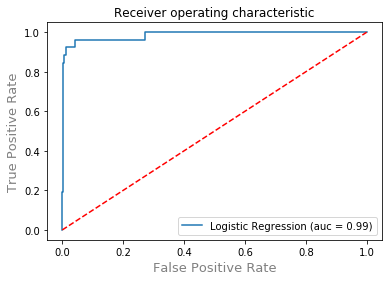

In [36]:
print()
print("Recall Training data:     ", np.round(recall_score(ytrain_OVS, OVS_grid.predict(Xtrain_OVS)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVS, OVS_grid.predict(Xtrain_OVS)), decimals=4))

print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, OVS_grid.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, OVS_grid.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, OVS_grid.predict(Xtest)))


print("----------------------------------------------------------------------")
print(classification_report(ytest, OVS_grid.predict(Xtest)))

y_pred_proba = OVS_grid.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()


The 'Recall' gauge increased to the level of 0.92, ratios 'precision' fall to the level 0.21.

# Class_weight

-----------------------------------------------------------------------------------------
Using class_weight is the method to improve 'recall' ratio in the unbalanced sets (unbalanced in result variable). Increase of 'recall' is in the expense of 'precision' ratio.

As we mentioned, in train set there 216 of variables marked 0 for one variable marked 1. To limit this disproportion we need to increase weigh of dependent variables marked 1 by 216 times.

In [37]:
Pw = sum(ytrain == 0) / sum(ytrain == 1)  # size to repeat y == 1
Pw = np.round(Pw, decimals=0)
Pw = Pw.astype(int)
Pw

216

Weight parameter 'positive weight', PW=216
We need to increase of variable 1, we need in the equation use range {0: 1, 2:216}.

In [38]:
Parameters = {'C': np.power(10.0, np.arange(-3, 3))}
LogReg = LogisticRegression(class_weight = {0 : 1, 1 : Pw}, warm_start = True, solver='lbfgs')

Tuning the model by the grid. 

In [39]:
LRV_Reg_grid = GridSearchCV(LogReg, param_grid = Parameters, scoring = 'roc_auc', n_jobs = 5, cv = 6)
LRV_Reg_grid.fit(Xtrain, ytrain)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight={0: 1, 1: 216}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=True),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

We check which hyperparameters were chosen.

In [40]:
print("The Best parameter:",LRV_Reg_grid.best_params_)
print("The Best estimator:",LRV_Reg_grid.best_estimator_)

The Best parameter: {'C': 0.001}
The Best estimator: LogisticRegression(C=0.001, class_weight={0: 1, 1: 216}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=True)


As usually turn on diagnostic module.


Recall Training data:      0.9444
Precision Training data:   0.2914
----------------------------------------------------------------------
Recall Test data:          0.8846
Precision Test data:       0.284
----------------------------------------------------------------------
Confusion Matrix Test data
[[5653   90]
 [   2   24]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5743
         1.0       0.28      0.88      0.43        26

   micro avg       0.99      0.99      0.99      5769
   macro avg       0.64      0.94      0.71      5769
weighted avg       1.00      0.99      0.99      5769



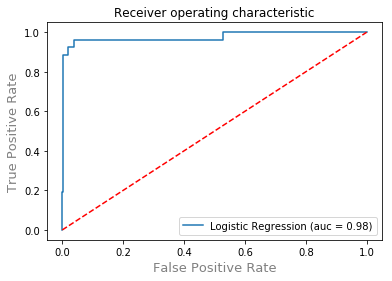

In [41]:
print()
print("Recall Training data:     ", np.round(recall_score(ytrain, LRV_Reg_grid.predict(Xtrain)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain, LRV_Reg_grid.predict(Xtrain)), decimals=4))

print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, LRV_Reg_grid.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, LRV_Reg_grid.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, OVS_grid.predict(Xtest)))


print("----------------------------------------------------------------------")
print(classification_report(ytest, LRV_Reg_grid.predict(Xtest)))

y_pred_proba = LRV_Reg_grid.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()


Thanks to apply class_weight, weight of dependent variables marked 1 was increased.
The 'Recall' gauge increased to the level of 0.88, ratios 'precision' fall to the level 0.28.

The same effect, can be achieved using automatically balancing with parameter class_weight="balanced".